In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# List of tickers (ETFs or stocks)
tickers = ['QDV5.DE', 'SXR8.DE', '0QYP.IL']  # Add or modify tickers as needed

# Calculate the date range for the past 5 years
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

# Function to fetch 5-year financial data for a given ticker
def get_financial_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(start=start_date, end=end_date)
    return hist[['Close', 'Volume']]

# Fetch data for all tickers
financial_data = {}
for ticker in tickers:
    try:
        financial_data[ticker] = get_financial_data(ticker)
        print(f"Data retrieved for {ticker}")
    except Exception as e:
        print(f"Error retrieving data for {ticker}: {str(e)}")

# Combine all data into a single DataFrame
combined_data = pd.concat(financial_data, axis=1)

# Round down to the nearest day and group
combined_data = combined_data.groupby(combined_data.index.floor('D')).last()

# Display the first few rows of the combined data
print(combined_data.head())

# Optional: Save the data to a CSV file
# combined_data.to_csv('financial_data_5yr.csv')


Data retrieved for QDV5.DE
Data retrieved for SXR8.DE
Data retrieved for 0QYP.IL
                          QDV5.DE              SXR8.DE              0QYP.IL  \
                            Close   Volume       Close   Volume       Close   
Date                                                                          
2019-10-03 00:00:00+00:00  4.6335  21725.0  264.970001  48695.0  130.257416   
2019-10-06 00:00:00+00:00  4.5935  22275.0  266.070007  28929.0  131.460846   
2019-10-07 00:00:00+00:00  4.5500   7671.0  262.190002  49732.0  131.651871   
2019-10-08 00:00:00+00:00  4.6160   5570.0  262.880005  70299.0  130.161880   
2019-10-09 00:00:00+00:00  4.6285   5973.0  264.910004  38179.0  131.518127   

                                     
                             Volume  
Date                                 
2019-10-03 00:00:00+00:00   26543.0  
2019-10-06 00:00:00+00:00  192001.0  
2019-10-07 00:00:00+00:00   52576.0  
2019-10-08 00:00:00+00:00   23732.0  
2019-10-09 00:00:00+

In [2]:
from portfolio_optimization.portfolio.Portfolio import Portfolio
from portfolio_optimization.optimization.black_litterman import BlackLitterman
from portfolio_optimization.optimization.risk_parity import RiskParity
from portfolio_optimization.optimization.markowitz import Markowitz
from main_backtest.delegates import (
    OptRebalancingPortfolioDelegate,
    CustomMarkowitzDelegate,
)
import pandas as pd
import numpy as np

# Extract 'Close' price columns from combined_data
df = combined_data.xs('Close', axis=1, level=1)

# Ensure the index is datetime, rounded to the nearest day and timezone unaware
df.index = pd.to_datetime(df.index).tz_localize(None)
# Set date time to 00:00:00 for each day
df.index = pd.to_datetime(df.index, format="%Y-%m-%d 00:00:00")

# Sort the index to ensure chronological order
df.sort_index(inplace=True)

# Forward fill the missing values
# Reindex df to fill missing dates
date_range = pd.date_range(start=df.index[0], end=df.index[-1]).drop_duplicates()
df = df[~df.index.duplicated(keep="first")]  # Remove duplicate labels
df = df.reindex(date_range, fill_value=np.nan)
df.ffill(inplace=True)

# Display the first few rows of the processed dataframe
print(df.head())

# Define variables needed for portfolio creation
max_weight = {"*": 0.3}  # Maximum weight per asset
min_weight = {"*": 0.0}  # Minimum weight per asset
chosen_delegate = OptRebalancingPortfolioDelegate()  # Placeholder for the delegate object

# Make sure start_date_portfolio is timezone unaware and includes hours
start_date_portfolio = pd.to_datetime("2021-06-24 00:00:00").tz_localize(None)

# Ensure initial_prices is always a DataFrame and use .loc with a timezone unaware date including hours
initial_prices_df = df.loc[:start_date_portfolio]
if isinstance(initial_prices_df, pd.Series):
    initial_prices_df = initial_prices_df.to_frame()

portfolio_parity = Portfolio(
    base_value=10000,
    initial_prices=initial_prices_df,
    optimiser=RiskParity,
    max_weight=1.0,
    min_weight=0.0,
    budget={},
    lambda_var=0.1,
    lambda_u=0.1,
)

portfolio_parity.delegate = chosen_delegate

portfolio_markowitz = Portfolio(
    base_value=10000,
    initial_prices=initial_prices_df,
    optimiser=Markowitz.bind(CustomMarkowitzDelegate()),
    max_weight=1.0,
    min_weight=0.0,
)

portfolio_markowitz.delegate = chosen_delegate

            QDV5.DE     SXR8.DE     0QYP.IL
2019-10-03   4.6335  264.970001  130.257416
2019-10-04   4.6335  264.970001  130.257416
2019-10-05   4.6335  264.970001  130.257416
2019-10-06   4.5935  266.070007  131.460846
2019-10-07   4.5500  262.190002  131.651871
Available assets: {'0QYP.IL', 'SXR8.DE', 'QDV5.DE'}
Assets to keep: ['0QYP.IL', 'SXR8.DE', 'QDV5.DE']
Computed covariance matrix shape: (3, 3).
Computed covariance matrix shape: (3, 3).

Processing constraints:

Final constraints:
  0QYP.IL: (0, 1.0)
  QDV5.DE: (0, 1.0)
  SXR8.DE: (0, 1.0)
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 02 10:28:08 PM: Your problem has 7 variables, 7 constraints, and 0 parameters.
(CVXPY) Oct 02 10:28:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 02 10:28:08 PM: (If you need to solve this problem multiple times, but with different data, conside

In [3]:
from portfolio_optimization.backtesting.Backtesting import Backtest

portfolios = {
    "Markowitz": portfolio_markowitz,
    # "BL": portfolio_bl,
    "Risk Parity": portfolio_parity,
    # "Fast Risk Parity": portfolio_fast_parity,
    # "Heuristic": portfolio_default,
    # "Reward to Risk": portfolio_rtr,
    # "Simple Volatility": portfolio_vo,
    # "Volatility of Volatility": portfolio_vov,
    # "Value At Risk": portfolio_var,
    # "Reward to VaR": portfolio_rvar,
    # "Combination": portfolio_combination,
}

backtest = Backtest(
    portfolios=portfolios,
    start_date=start_date_portfolio,
    end_date=df.index[-1],
    rebalance_frequency="1W",
    adjust_holdings=False,
    data=df,
    mcaps=df,
    asset_class="stocks",
    progress_logger=None,
)

perfs = backtest.run_backtest(
    look_back_period=120,
    look_back_unit="D",
    yield_data=None,
    progress_logger=None,
)

Available assets: {'0QYP.IL', 'QDV5.DE', 'SXR8.DE'}
Assets to keep: ['0QYP.IL', 'QDV5.DE', 'SXR8.DE']

Processing constraints:

Final constraints:
  0QYP.IL: (0, 1.0)
  QDV5.DE: (0, 1.0)
  SXR8.DE: (0, 1.0)
Sector: ['0QYP.IL', 'QDV5.DE', 'SXR8.DE']
Sector: allocation = 1
Weight bounds: [(0, 1.0), (0, 1.0), (0, 1.0)]
Available assets: {'SXR8.DE', '0QYP.IL', 'QDV5.DE'}
Assets to keep: ['SXR8.DE', '0QYP.IL', 'QDV5.DE']
[WEALTH VALUE]:  QDV5.DE        0.000000
SXR8.DE        0.000000
0QYP.IL    10075.186445
dtype: float64
Computed covariance matrix shape: (3, 3).
Computed covariance matrix shape: (3, 3).

Processing constraints:

Final constraints:
  0QYP.IL: (0, 1.0)
  QDV5.DE: (0, 1.0)
  SXR8.DE: (0, 1.0)
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 02 10:28:10 PM: Your problem has 7 variables, 7 constraints, and 0 parameters.
(CVXPY) Oct 02 10:28:10 PM: It is co

Markowitz
Risk Parity


<Axes: >

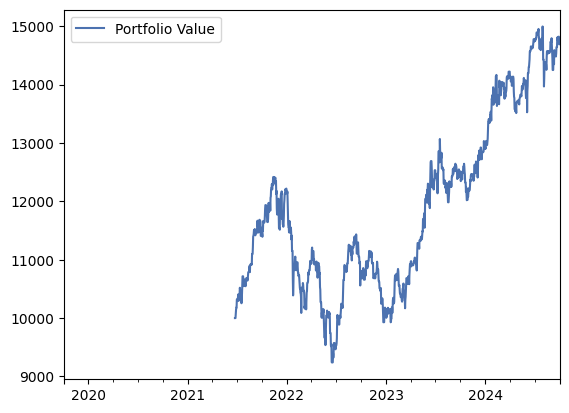

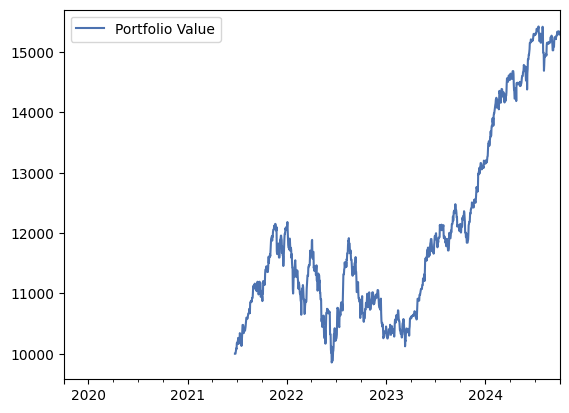

In [5]:
import matplotlib.pyplot as plt
# # Plot the first perf
print(perfs[0].name)
perfs[0].portfolio_value.plot()
print(perfs[1].name)
perfs[1].portfolio_value.plot()

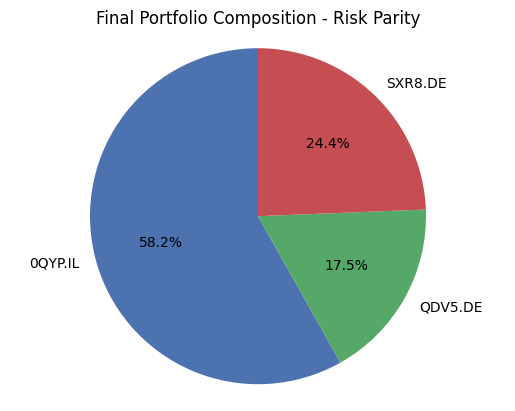

In [8]:
# Plot last composition as a pie chart
perfs[1].portfolio_compositions.iloc[-1].plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title(f"Final Portfolio Composition - {perfs[1].name}")
plt.show()